In [1]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
%matplotlib inline
import torchmetrics

# Check PyTorch version
torch.__version__

C:\Users\art\anaconda3\envs\pytorch\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


'1.13.1'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
##### Helper Imports

import requests
from pathlib import Path 

HELPER_NAME = 'plot_decision_boundary'
HELPER_PATH = 'https://raw.githubusercontent.com/gputrain/helpers/main/PyTorch/plot_decision_boundary.py'

if Path(HELPER_NAME+'.py').is_file():
    print(HELPER_NAME+'.py'  + " already exists, skipping download")
else:
    print("Downloading "+ HELPER_NAME+'.py')
    request = requests.get(HELPER_PATH)
    with open(HELPER_NAME+'.py', "wb") as f:
        f.write(request.content)
        
from plot_decision_boundary import plot_decision_boundary

plot_decision_boundary.py already exists, skipping download


##### 1. Generate the data

In [4]:
# Making circles data for classification

from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
#circles.head(10)

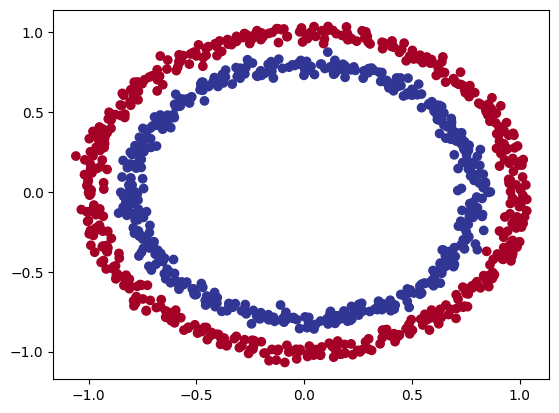

In [6]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

##### 2. Tensor datasets, model, loss function and optimizer setup

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Define three linear layers with 2 input features and 1 output feature
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        # Define ReLU activation function to introduce non-linearity
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply the linear layers and ReLU activation functions in sequence
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

# Move the model to the appropriate device (e.g., CPU or GPU)
model = CircleModel().to(device)
print(model)

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [10]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

##### 3. Model training

In [11]:
# Fit the model
torch.manual_seed(42)
epochs = 10000
patience = 1000 # Number of epochs to wait for improvement


# Create an accuracy metric object
accuracy_metric = torchmetrics.Accuracy(task='binary').to(device)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Variable to keep track of the best test accuracy
best_test_acc = 0.0

for epoch in range(epochs):
    ## 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    
    acc = accuracy_metric(y_pred, y_train) * 100

    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
        # 2. Calcuate loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        
        test_acc = accuracy_metric(y_test, test_pred) * 100

    # Check if test accuracy has improved
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0 # Reset patience counter if accuracy improves
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Stopping training. Test accuracy did not improve for {patience} epochs. Best Test Accuracy: {best_test_acc:.2f}%")
            break

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69858, Accuracy: 46.25% | Test Loss: 0.69726, Test Accuracy: 43.00%
Epoch: 100 | Loss: 0.69578, Accuracy: 37.75% | Test Loss: 0.69569, Test Accuracy: 42.50%
Epoch: 200 | Loss: 0.69445, Accuracy: 34.38% | Test Loss: 0.69489, Test Accuracy: 34.50%
Epoch: 300 | Loss: 0.69343, Accuracy: 46.50% | Test Loss: 0.69425, Test Accuracy: 46.50%
Epoch: 400 | Loss: 0.69249, Accuracy: 50.25% | Test Loss: 0.69368, Test Accuracy: 45.50%
Epoch: 500 | Loss: 0.69146, Accuracy: 51.75% | Test Loss: 0.69304, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69016, Accuracy: 52.88% | Test Loss: 0.69225, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.68842, Accuracy: 54.50% | Test Loss: 0.69121, Test Accuracy: 47.50%
Epoch: 800 | Loss: 0.68597, Accuracy: 56.63% | Test Loss: 0.68966, Test Accuracy: 49.50%
Epoch: 900 | Loss: 0.68237, Accuracy: 57.88% | Test Loss: 0.68720, Test Accuracy: 52.00%
Epoch: 1000 | Loss: 0.67673, Accuracy: 59.25% | Test Loss: 0.68297, Test Accuracy: 53.50%
Epoch: 1100 | Loss: 0.

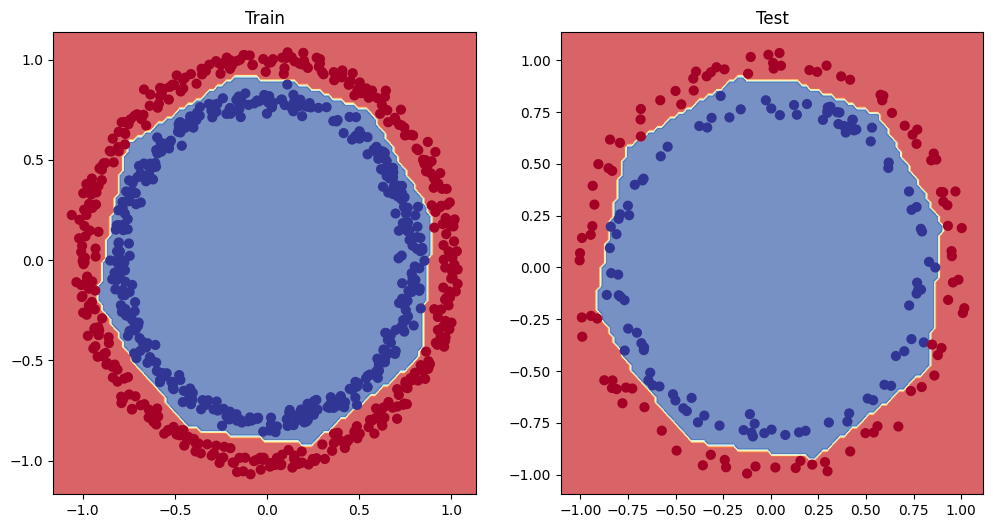

In [12]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) # model_3 = has non-linearity